In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers, optimizers
from keras.optimizers import Adam, RMSprop
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.models import load_model

# File Extracting
So our file is going to be in binary and we are going to need to get it out
You can thinks of this process of encoding and decoding, but allows us to store a large number of images, and the vectors, in a much smaller file

In [2]:
# this is a dictionairy used to define the structure
# of our binary file
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'title': tf.io.FixedLenFeature([], tf.string),
    'price': tf.io.FixedLenFeature([], tf.float32),
    'unbalanced_vector': tf.io.VarLenFeature(tf.int64),
    'balanced_vector': tf.io.VarLenFeature(tf.int64),
    'unbalanced_model_vector': tf.io.VarLenFeature(tf.int64),
    'unbalanced_brand_vector': tf.io.VarLenFeature(tf.int64),
}

In [3]:
# this is a function used to extract the binary information
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image'])
    title = tf.strings.lower(parsed_example['title'])
    price = parsed_example['price']
    unbalanced_vector = tf.sparse.to_dense(parsed_example['unbalanced_vector'])
    balanced_vector = tf.sparse.to_dense(parsed_example['balanced_vector'])
    unbalanced_model_vector = tf.sparse.to_dense(parsed_example['unbalanced_model_vector'])
    unbalanced_brand_vector = tf.sparse.to_dense(parsed_example['unbalanced_brand_vector'])
    return image, title, price, unbalanced_vector, balanced_vector, unbalanced_model_vector, unbalanced_brand_vector

In [4]:
dataset = tf.data.TFRecordDataset('Downloaded_Images_Binary_Brands_Models.tfrecords')
dataset = dataset.map(parse_example)


2023-11-25 18:25:29.079873: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-25 18:25:29.079900: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-25 18:25:29.079907: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-25 18:25:29.079943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-25 18:25:29.079971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Here some code to show we extracted everything correctly!

Unbalanced Vector: [0 1 0 0 0 0 0 0 0 0]
Balanced Vector: [0 1 0 0 0 0 0 0 0 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Brand Vector: [1 0 0 0 0 0]
tf.Tensor(107.0, shape=(), dtype=float32)


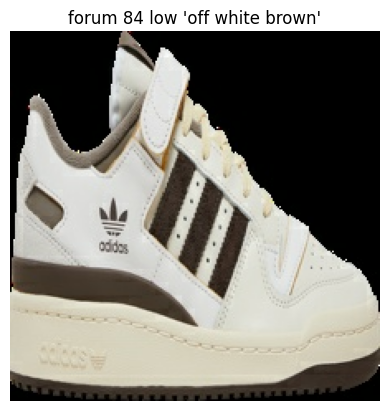

In [5]:
for image, title, price, unbalanced_vector, balanced_vector,unbalanced_model_vector,unbalanced_brand_vector in dataset.take(1):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print("Model Vector:", unbalanced_model_vector.numpy())
    print("Brand Vector:", unbalanced_brand_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

# Splitting up training and Testing Data
    * We are going to shuffle the data incase
    the website organizes the data in set, non-random
    way. 

## Base Dataset
    * No techniques except shuffling and shape!

In [6]:
# Size of Data
buffer_size = sum([1 for _ in dataset])  
# Shuffle the data
shuffled_dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=False)
# 80/20 Split, Taking will take the first 80% and skip will take the last
train_size = int(0.8 * buffer_size)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)

## Printing it out again to make sure everything looks right!

Unbalanced Vector: [0 0 0 0 1 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 0 0 0 1 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Brand Vector: [0 0 1 0 0 0]
tf.Tensor(459.0, shape=(), dtype=float32)


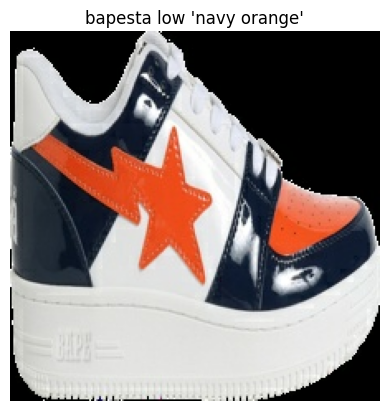

Unbalanced Vector: [0 0 1 0 0 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 1 0 0 0 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Brand Vector: [0 0 0 1 0 0]
tf.Tensor(244.0, shape=(), dtype=float32)


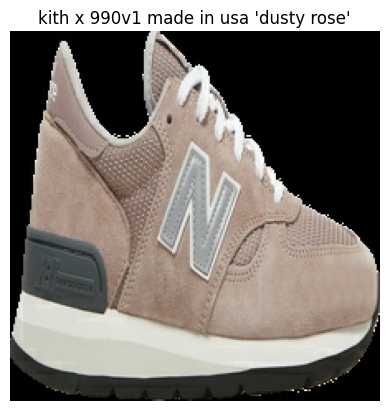

Unbalanced Vector: [0 0 0 0 0 1 0 0 0 0]
Balanced Vector: [0 0 0 0 0 0 0 0 1 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Brand Vector: [1 0 0 0 0 0]
tf.Tensor(507.0, shape=(), dtype=float32)


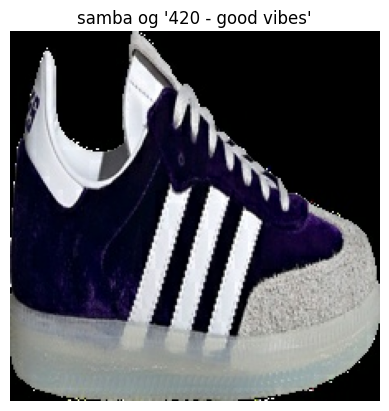

In [7]:
for image, title, price, unbalanced_vector, balanced_vector, unbalanced_model_vector,unbalanced_brand_vector in val_dataset.take(3):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print("Model Vector:", unbalanced_model_vector.numpy())
    print("Brand Vector:", unbalanced_brand_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

## Data Technique 1 - Normalization!
* This can be done simply by dividing by 255 (Pixel score)
* This will improve and is going to be necessary for vgg16

In [8]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector

unbalanced_vector_train_dataset = train_dataset.map(preprocess).batch(16)
unbalanced_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [9]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, balanced_vector

balanced_vector_train_dataset = train_dataset.map(preprocess).batch(16)
balanced_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [10]:
# This is a function to divide the image / 255, preprocess is 
# a function apart of keras and has certain rules, and it allows us to declare are predictor/response
# we are going to be using these keras functions a lot
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_brand_vector

brand_vector_train_dataset = train_dataset.map(preprocess).batch(16)
brand_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [11]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_model_vector

model_vector_train_dataset = train_dataset.map(preprocess).batch(16)
model_vector_val_dataset = val_dataset.map(preprocess).batch(16)

## Data Technique 2 - Data Augmentaton!
* This is a technique used to introduce variations to our training data and can have enourmouse
benefits

DID NOT HELP WITH THIS MODEL, KEEPING TO SHOW WHAT IT DOES

In [12]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector,unbalanced_brand_vector, augment = True):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    if augment:
        image = tf.image.random_flip_left_right(image)  
        image = tf.image.random_flip_up_down(image) 
        # image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
       
        # image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        
    return image, unbalanced_brand_vector

aug_train_dataset = train_dataset.map(preprocess).batch(16)
aug_val_dataset = val_dataset.map(preprocess).batch(16)



## Data Technique 3 - Class Weights!
* This is a technique used to balance data by providing a weight based on class size
* DID NOT HELP KEEPING TO SHOW WHAT IT DOES


In [13]:
# counts for our vector
class_counts = {
    'A':258,
    'B':489,
    'C':88,
    'D':115,
    'E':1390,
    'F':46,
}
# code to get the weights for each class
total_samples = sum(class_counts.values())
num_classes = len(class_counts)
class_weights = {class_label: (total_samples / (num_classes * count)) for class_label, count in class_counts.items()}
class_weights = {i: weight for i, (_, weight) in enumerate(class_weights.items())}

# Models
We are going to be using Tensorflow and Keras to build our model. Tensflow Keras allow us to build models incredibly easly. 
Each dataset will have two models (8 models)
1. Model 
    * Took from https://github.com/bnsreenu/python_for_microscopists/blob/master/142-multi_label_classification.py (slightly modified)
2. Modified Model
    * Experimented modifcatons such as Kernal size, 
    max pooling size, number of filters, dropout, 
    addtional dense layers and more. 
    * filter size was the most successful modification


## Unbalanced Price Models

In [14]:
# model is linear
unbalanced_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
unbalanced_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
unbalanced_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
unbalanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
unbalanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
unbalanced_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_vector)
# (6400) -> (10) output layers
unbalanced_model.add(Dense(vector_size, activation='softmax'))

unbalanced_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])

In [15]:
# model is linear
unbalanced_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 4, 4, outputs (220,220,16) (NO PADDING)
unbalanced_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 4, 4, outputs (106,106,32) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 4, 4, outputs (49,49,64) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 4, 4, outputs (20,20,64) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
unbalanced_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_vector)
# (6400) -> (10) output layers
unbalanced_model_modified.add(Dense(vector_size, activation='softmax'))
unbalanced_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])

## Balanced Models

In [16]:
# model is linear
balanced_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
balanced_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
balanced_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
balanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
balanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
balanced_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(balanced_vector)
# (6400) -> (10) output layers
balanced_model.add(Dense(vector_size, activation='softmax'))

balanced_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])

In [17]:
# model is linear
balanced_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 4, 4, outputs (220,220,16) (NO PADDING)
balanced_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 4, 4, outputs (106,106,32) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 4, 4, outputs (49,49,64) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 4, 4, outputs (20,20,64) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
balanced_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(balanced_vector)
# (6400) -> (10) output layers
balanced_model_modified.add(Dense(vector_size, activation='softmax'))
balanced_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])

## Brand Model

In [18]:
# model is linear
brand_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
brand_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
brand_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
brand_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
brand_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
brand_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_brand_vector)
# (6400) -> (10) output layers
brand_model.add(Dense(vector_size, activation='softmax'))

brand_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])

In [19]:
# model_test is linear
brand_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
brand_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
brand_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
brand_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
brand_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
brand_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_brand_vector)
# (6400) -> (10) output layers
brand_model_modified.add(Dense(vector_size, activation='softmax'))
brand_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])

## Model Model

In [20]:
# model is linear
model_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
model_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
model_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
model_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
model_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
model_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_model_vector)
# (6400) -> (10) output layers
model_model.add(Dense(vector_size, activation='softmax'))

model_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])

In [21]:
# model_test is linear
model_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
model_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
model_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
model_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
model_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
model_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_model_vector)
# (6400) -> (10) output layers
model_model_modified.add(Dense(vector_size, activation='softmax'))
model_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])

# Running the models and making predictions

## Tensor code to montitor our model and to save it!

In [22]:
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience= 4, 
                                        restore_best_weights=True)
                                        
model_checkpoint_callback = ModelCheckpoint(
    filepath='path/to/save/weights.h5', 
    save_weights_only=True,
    monitor='val_accuracy',  
    mode='max',  
    save_best_only=True  
)

## Unbalanced Price Models and Predictions

In [23]:
unbalanced_model.fit(unbalanced_vector_train_dataset, epochs=9, validation_data=unbalanced_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
unbalanced_model.save('unbalanced_model.keras')

Epoch 1/9


2023-11-25 18:25:33.786572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-25 18:25:33.868193: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 26s 40ms/step - loss: 0.3616 - accuracy: 0.2508

2023-11-25 18:25:59.219076: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15959882498015527112
2023-11-25 18:25:59.219099: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13803527626606278879
2023-11-25 18:25:59.219128: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13977161288868706359
2023-11-25 18:25:59.219134: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9843555341830214213
2023-11-25 18:25:59.219138: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 960921094553031602
2023-11-25 18:25:59.219164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 55177775657559500
2023-11-25 18:25:59.219166: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv ite

597/597 [==============================] - 29s 45ms/step - loss: 0.3616 - accuracy: 0.2508 - val_loss: 0.8182 - val_accuracy: 0.0180
Epoch 2/9


2023-11-25 18:26:02.549157: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8400102324694274718
2023-11-25 18:26:02.549176: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6969154767948968835
2023-11-25 18:26:02.549181: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886967201889919989
2023-11-25 18:26:02.549186: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3940528925838046821
2023-11-25 18:26:02.549190: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 384956647661584269
2023-11-25 18:26:02.549207: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9445894775732024864


597/597 [==============================] - 27s 44ms/step - loss: 0.3106 - accuracy: 0.2992 - val_loss: 0.3130 - val_accuracy: 0.3076
Epoch 3/9
597/597 [==============================] - 29s 47ms/step - loss: 0.2845 - accuracy: 0.3313 - val_loss: 0.2971 - val_accuracy: 0.3009
Epoch 4/9
597/597 [==============================] - 27s 44ms/step - loss: 0.2658 - accuracy: 0.3678 - val_loss: 0.2891 - val_accuracy: 0.3173
Epoch 5/9
597/597 [==============================] - 28s 45ms/step - loss: 0.2506 - accuracy: 0.4045 - val_loss: 0.2866 - val_accuracy: 0.3181
Epoch 6/9
597/597 [==============================] - 27s 44ms/step - loss: 0.2357 - accuracy: 0.4545 - val_loss: 0.2912 - val_accuracy: 0.3156
Epoch 7/9
597/597 [==============================] - 27s 44ms/step - loss: 0.2208 - accuracy: 0.4998 - val_loss: 0.3123 - val_accuracy: 0.3055
Epoch 8/9
597/597 [==============================] - 28s 46ms/step - loss: 0.2024 - accuracy: 0.5581 - val_loss: 0.3104 - val_accuracy: 0.2741
Epoch 9/9

In [24]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
unbalanced_model_modified.fit(unbalanced_vector_train_dataset, epochs=9, validation_data=unbalanced_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback]) 
unbalanced_model_modified.save('unbalanced_modified_model.keras')

Epoch 1/9


2023-11-25 18:29:44.936104: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 23s 36ms/step - loss: 0.3802 - accuracy: 0.2513

2023-11-25 18:30:07.763426: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15959882498015527112
2023-11-25 18:30:07.763438: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10938128809838711332
2023-11-25 18:30:07.763466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13803527626606278879
2023-11-25 18:30:07.763471: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13977161288868706359
2023-11-25 18:30:07.763477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9843555341830214213
2023-11-25 18:30:07.763481: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5131604810800486291
2023-11-25 18:30:07.763487: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

597/597 [==============================] - 27s 41ms/step - loss: 0.3802 - accuracy: 0.2513 - val_loss: 0.8048 - val_accuracy: 0.0947
Epoch 2/9


2023-11-25 18:30:10.904012: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3008275930948719120
2023-11-25 18:30:10.904031: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886967201889919989
2023-11-25 18:30:10.904041: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6969154767948968835
2023-11-25 18:30:10.904045: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3940528925838046821
2023-11-25 18:30:10.904049: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 384956647661584269
2023-11-25 18:30:10.904056: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9445894775732024864


597/597 [==============================] - 25s 40ms/step - loss: 0.3139 - accuracy: 0.2973 - val_loss: 0.3836 - val_accuracy: 0.2825
Epoch 3/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2783 - accuracy: 0.3440 - val_loss: 0.3258 - val_accuracy: 0.3013
Epoch 4/9
597/597 [==============================] - 25s 41ms/step - loss: 0.2572 - accuracy: 0.3923 - val_loss: 0.2905 - val_accuracy: 0.3101
Epoch 5/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2390 - accuracy: 0.4416 - val_loss: 0.2919 - val_accuracy: 0.3135
Epoch 6/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2237 - accuracy: 0.4874 - val_loss: 0.2921 - val_accuracy: 0.3156
Epoch 7/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2065 - accuracy: 0.5457 - val_loss: 0.3121 - val_accuracy: 0.2854
Epoch 8/9
597/597 [==============================] - 25s 40ms/step - loss: 0.1846 - accuracy: 0.6074 - val_loss: 0.3226 - val_accuracy: 0.2850


In [25]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector

unbalanced_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [26]:
predictions = unbalanced_model.predict(unbalanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
unbalanced_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    unbalanced_binary_predictions[i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


2023-11-25 18:33:08.654202: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5526923944493595584


In [27]:
predictions = unbalanced_model_modified.predict(unbalanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
unbalanced_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    unbalanced_binary_mod_predictions[i, max_index] = 1

150/150 [==============================] - 2s 9ms/step


2023-11-25 18:33:11.165714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5526923944493595584


## Balanced Price Models and Predictions

In [28]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
balanced_model.fit(balanced_vector_train_dataset, epochs=9, validation_data=balanced_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
balanced_model.save('balanced_model.keras')

Epoch 1/9


2023-11-25 18:33:11.763464: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 26s 41ms/step - loss: 0.4233 - accuracy: 0.1201

2023-11-25 18:33:37.160125: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15959882498015527112
2023-11-25 18:33:37.160139: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 960921094553031602
2023-11-25 18:33:37.160144: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 55177775657559500
2023-11-25 18:33:37.160149: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1902368672844518936
2023-11-25 18:33:37.160153: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16455204299333971964


597/597 [==============================] - 29s 46ms/step - loss: 0.4233 - accuracy: 0.1201 - val_loss: 0.6657 - val_accuracy: 0.1081
Epoch 2/9


2023-11-25 18:33:40.329604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15225120669805748940
2023-11-25 18:33:40.329623: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886967201889919989
2023-11-25 18:33:40.329627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6969154767948968835
2023-11-25 18:33:40.329662: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3940528925838046821
2023-11-25 18:33:40.329671: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 384956647661584269
2023-11-25 18:33:40.329685: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9445894775732024864


597/597 [==============================] - 28s 45ms/step - loss: 0.3611 - accuracy: 0.1571 - val_loss: 0.3425 - val_accuracy: 0.1521
Epoch 3/9
597/597 [==============================] - 27s 44ms/step - loss: 0.3275 - accuracy: 0.1929 - val_loss: 0.3283 - val_accuracy: 0.1777
Epoch 4/9
597/597 [==============================] - 27s 44ms/step - loss: 0.3079 - accuracy: 0.2413 - val_loss: 0.3253 - val_accuracy: 0.1957
Epoch 5/9
597/597 [==============================] - 27s 44ms/step - loss: 0.2924 - accuracy: 0.2874 - val_loss: 0.3300 - val_accuracy: 0.1819
Epoch 6/9
597/597 [==============================] - 27s 44ms/step - loss: 0.2807 - accuracy: 0.3302 - val_loss: 0.3314 - val_accuracy: 0.1764
Epoch 7/9
597/597 [==============================] - 28s 45ms/step - loss: 0.2666 - accuracy: 0.3787 - val_loss: 0.3452 - val_accuracy: 0.1878
Epoch 8/9
597/597 [==============================] - 27s 43ms/step - loss: 0.2490 - accuracy: 0.4369 - val_loss: 0.3644 - val_accuracy: 0.1785


In [29]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
balanced_model_modified.fit(balanced_vector_train_dataset, epochs=9, validation_data=balanced_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback]) 
balanced_model_modified.save('balanced_model_modified.keras')

Epoch 1/9


2023-11-25 18:36:52.825330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 23s 35ms/step - loss: 0.4410 - accuracy: 0.1280

2023-11-25 18:37:15.088647: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15959882498015527112
2023-11-25 18:37:15.088660: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13977161288868706359
2023-11-25 18:37:15.088665: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13803527626606278879
2023-11-25 18:37:15.088670: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9843555341830214213
2023-11-25 18:37:15.088674: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6301442411970703159
2023-11-25 18:37:15.088677: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5131604810800486291
2023-11-25 18:37:15.088683: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

597/597 [==============================] - 26s 41ms/step - loss: 0.4410 - accuracy: 0.1280 - val_loss: 0.6986 - val_accuracy: 0.1002
Epoch 2/9


2023-11-25 18:37:18.198119: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12088356835529289454
2023-11-25 18:37:18.198141: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6969154767948968835
2023-11-25 18:37:18.198146: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886967201889919989
2023-11-25 18:37:18.198150: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3940528925838046821
2023-11-25 18:37:18.198154: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 384956647661584269
2023-11-25 18:37:18.198167: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9445894775732024864


597/597 [==============================] - 25s 40ms/step - loss: 0.3624 - accuracy: 0.1673 - val_loss: 0.5351 - val_accuracy: 0.1282
Epoch 3/9
597/597 [==============================] - 25s 40ms/step - loss: 0.3226 - accuracy: 0.2204 - val_loss: 0.5244 - val_accuracy: 0.1429
Epoch 4/9
597/597 [==============================] - 25s 40ms/step - loss: 0.3005 - accuracy: 0.2687 - val_loss: 0.4623 - val_accuracy: 0.1471
Epoch 5/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2853 - accuracy: 0.3193 - val_loss: 0.4098 - val_accuracy: 0.1450
Epoch 6/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2694 - accuracy: 0.3720 - val_loss: 0.3984 - val_accuracy: 0.1517
Epoch 7/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2532 - accuracy: 0.4301 - val_loss: 0.3940 - val_accuracy: 0.1614
Epoch 8/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2343 - accuracy: 0.4904 - val_loss: 0.3637 - val_accuracy: 0.1744
Epoch 9/9

In [30]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, balanced_vector

balanced_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [31]:
predictions = balanced_model.predict(balanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
balanced_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    balanced_binary_predictions[i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


In [32]:
predictions = balanced_model_modified.predict(balanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
balanced_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    balanced_binary_mod_predictions[i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


2023-11-25 18:40:40.842654: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5526923944493595584


## Brand Models and Predictions

In [33]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
brand_model.fit(brand_vector_train_dataset, epochs=9, validation_data=brand_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
brand_model.save('brand_model.keras')

Epoch 1/9


2023-11-25 18:40:41.541463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 25s 39ms/step - loss: 0.2158 - accuracy: 0.7735

2023-11-25 18:41:06.272618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13977161288868706359
2023-11-25 18:41:06.272633: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13803527626606278879
2023-11-25 18:41:06.272638: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9843555341830214213
2023-11-25 18:41:06.272642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5131604810800486291
2023-11-25 18:41:06.272659: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15959882498015527112
2023-11-25 18:41:06.272682: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16320063593229175608
2023-11-25 18:41:06.272689: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

597/597 [==============================] - 29s 45ms/step - loss: 0.2158 - accuracy: 0.7735 - val_loss: 0.3744 - val_accuracy: 0.6664
Epoch 2/9


2023-11-25 18:41:09.389241: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3940528925838046821
2023-11-25 18:41:09.389260: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6969154767948968835
2023-11-25 18:41:09.389265: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886967201889919989
2023-11-25 18:41:09.389271: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18169069501342391927
2023-11-25 18:41:09.389274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 384956647661584269
2023-11-25 18:41:09.389287: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9445894775732024864


597/597 [==============================] - 27s 44ms/step - loss: 0.0925 - accuracy: 0.9151 - val_loss: 0.0884 - val_accuracy: 0.9141
Epoch 3/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0504 - accuracy: 0.9581 - val_loss: 0.0607 - val_accuracy: 0.9476
Epoch 4/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0291 - accuracy: 0.9801 - val_loss: 0.0579 - val_accuracy: 0.9535
Epoch 5/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0203 - accuracy: 0.9907 - val_loss: 0.0885 - val_accuracy: 0.9267
Epoch 6/9
597/597 [==============================] - 28s 45ms/step - loss: 0.0173 - accuracy: 0.9925 - val_loss: 0.0729 - val_accuracy: 0.9489
Epoch 7/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0183 - accuracy: 0.9927 - val_loss: 0.0691 - val_accuracy: 0.9510
Epoch 8/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0180 - accuracy: 0.9915 - val_loss: 0.0709 - val_accuracy: 0.9476


In [34]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
brand_model_modified.fit(brand_vector_train_dataset, epochs=9, validation_data=brand_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback]) 
brand_model_modified.save('brand_model_modified.keras')

Epoch 1/9


2023-11-25 18:44:20.637258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 23s 36ms/step - loss: 0.2084 - accuracy: 0.7930

2023-11-25 18:44:43.378010: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15959882498015527112
2023-11-25 18:44:43.378021: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10938128809838711332
2023-11-25 18:44:43.378035: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13977161288868706359
2023-11-25 18:44:43.378039: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13803527626606278879
2023-11-25 18:44:43.378047: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9843555341830214213
2023-11-25 18:44:43.378052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5131604810800486291
2023-11-25 18:44:43.378060: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

597/597 [==============================] - 27s 41ms/step - loss: 0.2084 - accuracy: 0.7930 - val_loss: 0.5037 - val_accuracy: 0.6844
Epoch 2/9


2023-11-25 18:44:46.594249: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886967201889919989
2023-11-25 18:44:46.594266: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6969154767948968835
2023-11-25 18:44:46.594277: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3940528925838046821
2023-11-25 18:44:46.594281: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 384956647661584269
2023-11-25 18:44:46.594290: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9445894775732024864
2023-11-25 18:44:46.594294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15977255042187990842


597/597 [==============================] - 25s 40ms/step - loss: 0.0888 - accuracy: 0.9200 - val_loss: 0.0791 - val_accuracy: 0.9338
Epoch 3/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0491 - accuracy: 0.9632 - val_loss: 0.2520 - val_accuracy: 0.8181
Epoch 4/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0301 - accuracy: 0.9804 - val_loss: 0.0669 - val_accuracy: 0.9480
Epoch 5/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0232 - accuracy: 0.9883 - val_loss: 0.1108 - val_accuracy: 0.9267
Epoch 6/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0201 - accuracy: 0.9905 - val_loss: 0.0669 - val_accuracy: 0.9455
Epoch 7/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0183 - accuracy: 0.9931 - val_loss: 0.0848 - val_accuracy: 0.9556
Epoch 8/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0191 - accuracy: 0.9918 - val_loss: 0.0804 - val_accuracy: 0.9480
Epoch 9/9

In [35]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_brand_vector

brand_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [36]:
predictions = brand_model.predict(brand_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
brand_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    brand_binary_predictions[i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


2023-11-25 18:48:09.714917: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5526923944493595584


In [37]:
predictions = brand_model_modified.predict(brand_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
brand_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    brand_binary_mod_predictions [i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


2023-11-25 18:48:12.311531: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5526923944493595584


## Model Models and Predictions

In [38]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
model_model.fit(model_vector_train_dataset, epochs=9, validation_data=model_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
model_model.save('model_model.keras')

Epoch 1/9


2023-11-25 18:48:12.927374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 26s 41ms/step - loss: 0.0903 - accuracy: 0.6724

2023-11-25 18:48:38.378404: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13977161288868706359
2023-11-25 18:48:38.378417: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15959882498015527112
2023-11-25 18:48:38.378424: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5529663034777294054
2023-11-25 18:48:38.378429: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 55177775657559500
2023-11-25 18:48:38.378432: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13803527626606278879
2023-11-25 18:48:38.378463: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5131604810800486291


597/597 [==============================] - 29s 46ms/step - loss: 0.0903 - accuracy: 0.6724 - val_loss: 0.1921 - val_accuracy: 0.6991
Epoch 2/9


2023-11-25 18:48:41.658495: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13747421556727140427
2023-11-25 18:48:41.658510: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886967201889919989
2023-11-25 18:48:41.658515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6969154767948968835
2023-11-25 18:48:41.658518: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3940528925838046821
2023-11-25 18:48:41.658522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 384956647661584269
2023-11-25 18:48:41.658529: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9445894775732024864


597/597 [==============================] - 28s 44ms/step - loss: 0.0288 - accuracy: 0.9147 - val_loss: 0.0304 - val_accuracy: 0.9233
Epoch 3/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0157 - accuracy: 0.9595 - val_loss: 0.0338 - val_accuracy: 0.9338
Epoch 4/9
597/597 [==============================] - 28s 46ms/step - loss: 0.0104 - accuracy: 0.9780 - val_loss: 0.0434 - val_accuracy: 0.9250
Epoch 5/9
597/597 [==============================] - 28s 45ms/step - loss: 0.0088 - accuracy: 0.9817 - val_loss: 0.0301 - val_accuracy: 0.9321
Epoch 6/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0083 - accuracy: 0.9829 - val_loss: 0.0290 - val_accuracy: 0.9271
Epoch 7/9
597/597 [==============================] - 27s 44ms/step - loss: 0.0080 - accuracy: 0.9856 - val_loss: 0.0287 - val_accuracy: 0.9426
Epoch 8/9
597/597 [==============================] - 28s 45ms/step - loss: 0.0066 - accuracy: 0.9890 - val_loss: 0.0311 - val_accuracy: 0.9405
Epoch 9/9

In [39]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
model_model_modified.fit(model_vector_train_dataset, epochs=9, validation_data=model_vector_val_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])
model_model_modified.save('model_model_modified.keras')

Epoch 1/9


2023-11-25 18:52:23.390227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 24s 36ms/step - loss: 0.0830 - accuracy: 0.7156

2023-11-25 18:52:46.450318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15959882498015527112
2023-11-25 18:52:46.450330: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10938128809838711332
2023-11-25 18:52:46.450338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13803527626606278879
2023-11-25 18:52:46.450342: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13977161288868706359
2023-11-25 18:52:46.450347: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9843555341830214213
2023-11-25 18:52:46.450356: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5131604810800486291
2023-11-25 18:52:46.450378: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

597/597 [==============================] - 27s 42ms/step - loss: 0.0830 - accuracy: 0.7156 - val_loss: 0.3002 - val_accuracy: 0.6492
Epoch 2/9


2023-11-25 18:52:49.750423: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2949638262339400424
2023-11-25 18:52:49.750442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886967201889919989
2023-11-25 18:52:49.750449: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6969154767948968835
2023-11-25 18:52:49.750453: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3940528925838046821
2023-11-25 18:52:49.750457: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 384956647661584269
2023-11-25 18:52:49.750471: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9445894775732024864


597/597 [==============================] - 25s 41ms/step - loss: 0.0256 - accuracy: 0.9323 - val_loss: 0.0275 - val_accuracy: 0.9380
Epoch 3/9
597/597 [==============================] - 25s 40ms/step - loss: 0.0138 - accuracy: 0.9666 - val_loss: 0.0305 - val_accuracy: 0.9334
Epoch 4/9
597/597 [==============================] - 25s 41ms/step - loss: 0.0104 - accuracy: 0.9787 - val_loss: 0.0283 - val_accuracy: 0.9413
Epoch 5/9
597/597 [==============================] - 25s 41ms/step - loss: 0.0085 - accuracy: 0.9844 - val_loss: 0.0249 - val_accuracy: 0.9443
Epoch 6/9
597/597 [==============================] - 25s 41ms/step - loss: 0.0074 - accuracy: 0.9862 - val_loss: 0.0295 - val_accuracy: 0.9468
Epoch 7/9
597/597 [==============================] - 25s 41ms/step - loss: 0.0075 - accuracy: 0.9870 - val_loss: 0.0361 - val_accuracy: 0.9380
Epoch 8/9
597/597 [==============================] - 25s 41ms/step - loss: 0.0078 - accuracy: 0.9883 - val_loss: 0.0725 - val_accuracy: 0.8265
Epoch 9/9

In [40]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_model_vector

model_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [41]:
predictions = model_model.predict(model_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
model_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    model_binary_predictions[i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


2023-11-25 18:56:13.924802: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5526923944493595584


In [42]:
predictions = model_model_modified.predict(model_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
model_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    model_binary_mod_predictions[i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


2023-11-25 18:56:16.500976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5526923944493595584


# Evaluation

## True vs Pred
* Here is some code to extract our labels and predictions. Because we are running our code on batches, we have unpack the batches, we can then covert it from a tf tensor to numpy array
* There are 8 Evaluations total and all will be combined into 1 final evaluation

In [43]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Unbalanced Price Model Evaluation

In [44]:
unbalanced_price_list = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600',
'600-700', '700-800', '800-900', '900+']

### Original

In [45]:
true_labels = []
predicted_labels = []

binary_predictions_list = unbalanced_binary_predictions.tolist()
prediction_count = 0

for batch in unbalanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)


(2386, 10)
(2386, 10)


In [46]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
unbalanced_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(unbalanced_cm)

[[ 61 199  53   1   2   1   0   0   0   3]
 [ 55 480 164   7   7  15   0   0   0  18]
 [ 21 191 165   3   9  17   0   0   1  21]
 [ 12 135  94  12   5  18   0   0   0  11]
 [ 12  66  51   2  10  10   1   0   0   6]
 [  3  52  42   1   2   6   0   1   0   5]
 [  3  27  14   2   3   1   1   0   0   4]
 [  2  26  25   0   2   1   0   0   0   5]
 [  0  11   3   0   1   0   0   0   0   1]
 [ 12  86  60   5   3  13   0   0   0  24]]


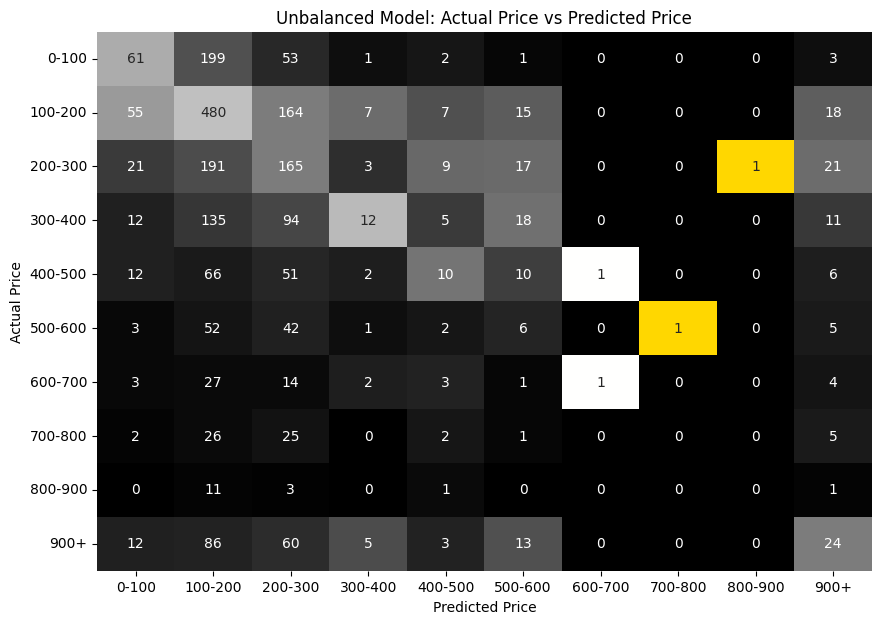

In [47]:
cm_df = pd.DataFrame(unbalanced_cm, index=unbalanced_price_list, columns=unbalanced_price_list)

column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Unbalanced Model: Actual Price vs Predicted Price')
plt.show()

In [48]:
unbalanced_accuracy = accuracy_score(true_labels, predicted_labels)
unbalanced_precision = precision_score(true_labels, predicted_labels, average='macro')
unbalanced_recall = recall_score(true_labels, predicted_labels, average='macro')
unbalanced_f1 = f1_score(true_labels, predicted_labels, average='macro')
unbalanced_report = classification_report(true_labels, predicted_labels, target_names=unbalanced_price_list)

unbalanced_metrics = pd.DataFrame([{
    'Model': 'Unbalanced Price Model',
    'Accuracy': unbalanced_accuracy,
    'Precision': unbalanced_precision,
    'Recall': unbalanced_recall,
    'F1 Score': unbalanced_f1
}])
metrics_df = pd.concat([metrics_df, unbalanced_metrics], ignore_index=True)


print(f"Unbalanced Accuracy: {unbalanced_accuracy}")
print(f"Unbalanced Precision: {unbalanced_precision}")
print(f"Unbalanced Recall: {unbalanced_recall}")
print(f"Unbalanced F1 Score: {unbalanced_f1}")
print(unbalanced_report)

Unbalanced Accuracy: 0.318105616093881
Unbalanced Precision: 0.23689580538603794
Unbalanced Recall: 0.1514653487749199
Unbalanced F1 Score: 0.14496905907465887
              precision    recall  f1-score   support

       0-100       0.34      0.19      0.24       320
     100-200       0.38      0.64      0.48       746
     200-300       0.25      0.39      0.30       428
     300-400       0.36      0.04      0.08       287
     400-500       0.23      0.06      0.10       158
     500-600       0.07      0.05      0.06       112
     600-700       0.50      0.02      0.04        55
     700-800       0.00      0.00      0.00        61
     800-900       0.00      0.00      0.00        16
        900+       0.24      0.12      0.16       203

   micro avg       0.32      0.32      0.32      2386
   macro avg       0.24      0.15      0.14      2386
weighted avg       0.30      0.32      0.27      2386
 samples avg       0.32      0.32      0.32      2386



/var/folders/9q/kg9gzt1s4d36gdnlr8nf75m40000gn/T/ipykernel_14176/4210602627.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, unbalanced_metrics], ignore_index=True)


### Modified

In [49]:
true_labels = []
predicted_labels = []

binary_predictions_list = unbalanced_binary_mod_predictions.tolist()
prediction_count = 0

for batch in unbalanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 10)
(2386, 10)


In [50]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
unbalanced_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(unbalanced_modified_cm)

[[ 32 230  46   1   0   2   0   1   1   7]
 [ 23 498 176   6   4  28   0   2   1   8]
 [  7 209 172   1   6  22   1   0   2   8]
 [  6 122 112   7   2  29   1   3   0   5]
 [  4  72  58   3   0  15   1   1   0   4]
 [  1  52  44   1   0  10   0   1   0   3]
 [  0  23  25   0   1   1   2   0   0   3]
 [  2  24  26   1   0   1   0   0   0   7]
 [  0   8   4   1   0   0   0   1   0   2]
 [  1  77  76   5   4  20   1   0   0  19]]


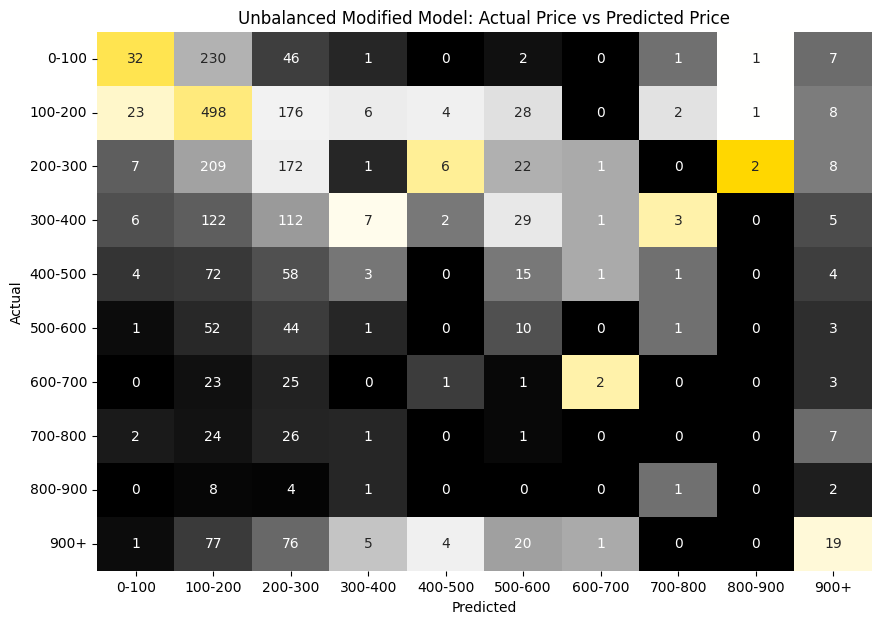

In [51]:
cm_df = pd.DataFrame(unbalanced_modified_cm, index=unbalanced_price_list, columns=unbalanced_price_list)
column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Unbalanced Modified Model: Actual Price vs Predicted Price')
plt.show()

In [52]:
unbalanced_modified_accuracy = accuracy_score(true_labels, predicted_labels)
unbalanced_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_report = classification_report(true_labels, predicted_labels, target_names=unbalanced_price_list)

unbalanced_modified_metrics = pd.DataFrame([{
    'Model': 'Unbalanced Modified Price Model',
    'Accuracy': unbalanced_modified_accuracy,
    'Precision': unbalanced_modified_precision,
    'Recall': unbalanced_modified_recall,
    'F1 Score': unbalanced_modified_f1
}])
metrics_df = pd.concat([metrics_df, unbalanced_modified_metrics], ignore_index=True)



print(f"Unbalanced Modified Accuracy: {unbalanced_modified_accuracy}")
print(f"Unbalanced Modified Precision: {unbalanced_modified_precision}")
print(f"Unbalanced Modified Recall: {unbalanced_modified_recall}")
print(f"Unbalanced Modified F1 Score: {unbalanced_modified_f1}")
print(unbalanced_modified_report)

Unbalanced Modified Accuracy: 0.3101424979044426
Unbalanced Modified Precision: 0.20010747017014996
Unbalanced Modified Recall: 0.14130651342594125
Unbalanced Modified F1 Score: 0.12745491156183647
              precision    recall  f1-score   support

       0-100       0.42      0.10      0.16       320
     100-200       0.38      0.67      0.48       746
     200-300       0.23      0.40      0.29       428
     300-400       0.27      0.02      0.04       287
     400-500       0.00      0.00      0.00       158
     500-600       0.08      0.09      0.08       112
     600-700       0.33      0.04      0.07        55
     700-800       0.00      0.00      0.00        61
     800-900       0.00      0.00      0.00        16
        900+       0.29      0.09      0.14       203

   micro avg       0.31      0.31      0.31      2386
   macro avg       0.20      0.14      0.13      2386
weighted avg       0.28      0.31      0.25      2386
 samples avg       0.31      0.31      0.31 

## Balanced Price Model Evaluation

In [53]:
balanced_price_list = ['17-93', '93-116', '116-143', '143-177', '177-217', '217-272',
'272-340', '340-457', '457-766', '766+']

### Original 

In [54]:
true_labels = []
predicted_labels = []

binary_predictions_list = balanced_binary_predictions.tolist()
prediction_count = 0

for batch in balanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 10)
(2386, 10)


In [55]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
balanced_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(balanced_cm)

[[103  25  42  15   0  20   5   4  10  30]
 [ 62  39  55  11   0  38   4   2  16  29]
 [ 30  39  60  20   0  31   7   1   6  34]
 [ 14  22  43  24   0  40   9   7  17  30]
 [ 17  21  48  20   2  54   8   4  18  45]
 [ 11  18  34  13   3  74  12  10  27  36]
 [ 14  19  22   9   2  59  14  11  35  29]
 [ 13  17  34  15   2  58  21  18  37  39]
 [ 10  16  36   9   3  46  11  19  40  70]
 [ 14  13  27  12   4  32  12   6  26  93]]


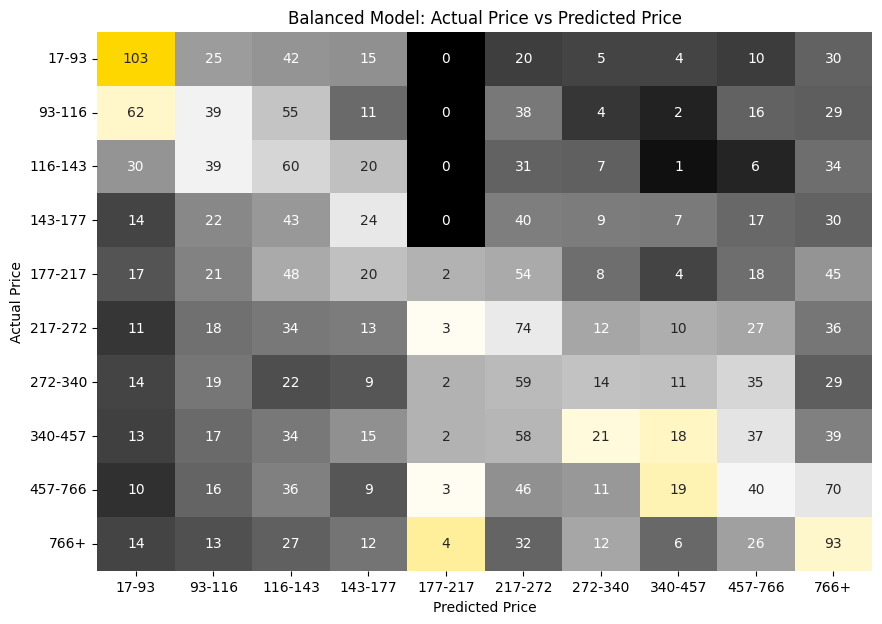

In [56]:
cm_df = pd.DataFrame(balanced_cm, index=balanced_price_list, columns=balanced_price_list)

column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Balanced Model: Actual Price vs Predicted Price')
plt.show()

In [57]:
balanced_accuracy = accuracy_score(true_labels, predicted_labels)
balanced_precision = precision_score(true_labels, predicted_labels, average='macro')
balanced_recall = recall_score(true_labels, predicted_labels, average='macro')
balanced_f1 = f1_score(true_labels, predicted_labels, average='macro')
balanced_report = classification_report(true_labels, predicted_labels, target_names=balanced_price_list)

balanced_metrics = pd.DataFrame([{
    'Model': 'Balanced Price Model',
    'Accuracy': balanced_accuracy,
    'Precision': balanced_precision,
    'Recall': balanced_recall,
    'F1 Score': balanced_f1
}])
metrics_df = pd.concat([metrics_df, balanced_metrics], ignore_index=True)

print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"Balanced Precision: {balanced_precision}")
print(f"Balanced Recall: {balanced_recall}")
print(f"Balanced F1 Score: {balanced_f1}")
print(balanced_report)

Balanced Accuracy: 0.19572506286672256
Balanced Precision: 0.1870090898999096
Balanced Recall: 0.1936135693680931
Balanced F1 Score: 0.1731610758516779
              precision    recall  f1-score   support

       17-93       0.36      0.41      0.38       254
      93-116       0.17      0.15      0.16       256
     116-143       0.15      0.26      0.19       228
     143-177       0.16      0.12      0.14       206
     177-217       0.12      0.01      0.02       237
     217-272       0.16      0.31      0.21       238
     272-340       0.14      0.07      0.09       214
     340-457       0.22      0.07      0.11       254
     457-766       0.17      0.15      0.16       260
        766+       0.21      0.39      0.28       239

   micro avg       0.20      0.20      0.20      2386
   macro avg       0.19      0.19      0.17      2386
weighted avg       0.19      0.20      0.18      2386
 samples avg       0.20      0.20      0.20      2386



### Modified 

In [58]:
true_labels = []
predicted_labels = []

binary_predictions_list = balanced_binary_mod_predictions.tolist()
prediction_count = 0

for batch in balanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 10)
(2386, 10)


In [59]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
balanced_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(balanced_modified_cm)

[[56 64 30  2 11 24 27 10 19 11]
 [33 62 41  2 10 21 27 14 24 22]
 [13 41 54  1 10 24 39 10 20 16]
 [ 7 18 39  2 11 33 40 18 21 17]
 [11 26 39  1 13 32 51 15 24 25]
 [ 8 23 28  3 13 38 51 19 32 23]
 [ 4 21 15  1  8 30 60 17 33 25]
 [ 7 16 16  0  7 31 59 48 48 22]
 [ 8 21 24  0  5 25 51 31 61 34]
 [ 2 24 31  1  4 20 48 20 44 45]]


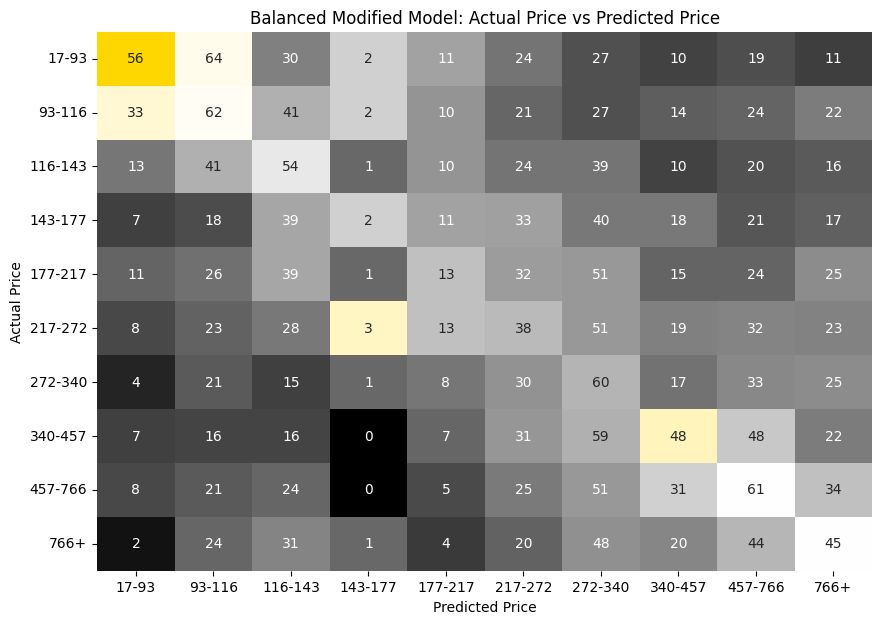

In [60]:
cm_df = pd.DataFrame(balanced_modified_cm, index=balanced_price_list, columns=balanced_price_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Balanced Modified Model: Actual Price vs Predicted Price')
plt.show()

In [61]:
balanced_modified_accuracy = accuracy_score(true_labels, predicted_labels)
balanced_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
balanced_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
balanced_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
balanced_modified_report = classification_report(true_labels, predicted_labels, target_names=balanced_price_list)

balanced_modified_metrics = pd.DataFrame([{
    'Model': 'Balanced Modified Price Model',
    'Accuracy': balanced_modified_accuracy,
    'Precision': balanced_modified_precision,
    'Recall': balanced_modified_recall,
    'F1 Score': balanced_modified_f1
}])
metrics_df = pd.concat([metrics_df, balanced_modified_metrics], ignore_index=True)


print(f"Balanced Accuracy: {balanced_modified_accuracy}")
print(f"Balanced Precision: {balanced_modified_precision}")
print(f"Balanced Recall: {balanced_modified_recall}")
print(f"Balanced F1 Score: {balanced_modified_f1}")
print(balanced_modified_report)

Balanced Accuracy: 0.18398994132439228
Balanced Precision: 0.1918920268048139
Balanced Recall: 0.18159770834657346
Balanced F1 Score: 0.17239619322113056
              precision    recall  f1-score   support

       17-93       0.38      0.22      0.28       254
      93-116       0.20      0.24      0.22       256
     116-143       0.17      0.24      0.20       228
     143-177       0.15      0.01      0.02       206
     177-217       0.14      0.05      0.08       237
     217-272       0.14      0.16      0.15       238
     272-340       0.13      0.28      0.18       214
     340-457       0.24      0.19      0.21       254
     457-766       0.19      0.23      0.21       260
        766+       0.19      0.19      0.19       239

   micro avg       0.18      0.18      0.18      2386
   macro avg       0.19      0.18      0.17      2386
weighted avg       0.19      0.18      0.18      2386
 samples avg       0.18      0.18      0.18      2386



## Brand Model Evaluation

In [62]:
brand_list = ['ADIDAS', 'AIR JORDAN', 'BAPESTA', 'NEW BALANCE', 'NIKE', 'YEEZY']

### Original 

In [63]:
true_labels = []
predicted_labels = []

binary_predictions_list = brand_binary_predictions.tolist()
prediction_count = 0

for batch in brand_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 6)
(2386, 6)


In [64]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
brand_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(brand_cm)

[[ 268    9    0    0    5    0]
 [   2  423    2    0   30    0]
 [   1    6   79    2    8    0]
 [   0    1    0  111    3    0]
 [   4   26   10    1 1344    0]
 [   0    0    0    0    1   50]]


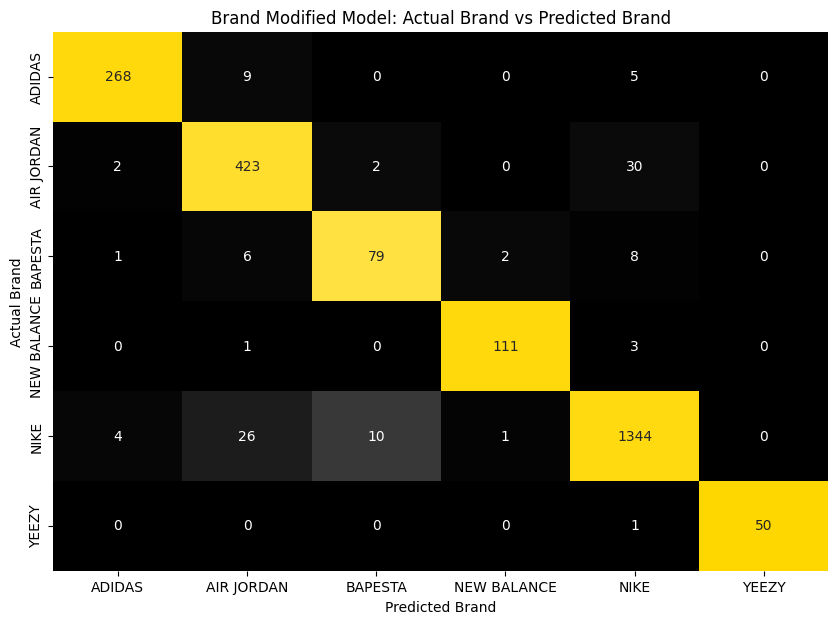

In [65]:
cm_df = pd.DataFrame(brand_cm, index=brand_list, columns=brand_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Brand')
plt.xlabel('Predicted Brand')
plt.title('Brand Modified Model: Actual Brand vs Predicted Brand')
plt.show()

In [66]:
brand_accuracy = accuracy_score(true_labels, predicted_labels)
brand_precision = precision_score(true_labels, predicted_labels, average='macro')
brand_recall = recall_score(true_labels, predicted_labels, average='macro')
brand_f1 = f1_score(true_labels, predicted_labels, average='macro')
brand_report = classification_report(true_labels, predicted_labels, target_names=brand_list)

brand_metrics = pd.DataFrame([{
    'Model': 'Brand Model',
    'Accuracy': brand_accuracy,
    'Precision': brand_precision,
    'Recall': brand_recall,
    'F1 Score': brand_f1
}])
metrics_df = pd.concat([metrics_df, brand_metrics], ignore_index=True)


print(f"Brand Accuracy: {brand_accuracy}")
print(f"Brand Precision: {brand_precision}")
print(f"Brand Recall: {brand_recall}")
print(f"Brand F1 Score: {brand_f1}")
print(brand_report)

Brand Accuracy: 0.9534786253143336
Brand Precision: 0.9487083852155335
Brand Recall: 0.9358132812038734
Brand F1 Score: 0.94210322437889
              precision    recall  f1-score   support

      ADIDAS       0.97      0.95      0.96       282
  AIR JORDAN       0.91      0.93      0.92       457
     BAPESTA       0.87      0.82      0.84        96
 NEW BALANCE       0.97      0.97      0.97       115
        NIKE       0.97      0.97      0.97      1385
       YEEZY       1.00      0.98      0.99        51

   micro avg       0.95      0.95      0.95      2386
   macro avg       0.95      0.94      0.94      2386
weighted avg       0.95      0.95      0.95      2386
 samples avg       0.95      0.95      0.95      2386



### Modified

In [67]:
true_labels = []
predicted_labels = []

binary_predictions_list = brand_binary_mod_predictions.tolist()
prediction_count = 0

for batch in brand_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 6)
(2386, 6)


In [68]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
brand_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(brand_modified_cm)

[[ 274    2    0    0    6    0]
 [   1  431    1    0   24    0]
 [   5    5   67    1   17    1]
 [   0    1    0  112    2    0]
 [   3   20    1    0 1361    0]
 [   0    0    0    0    0   51]]


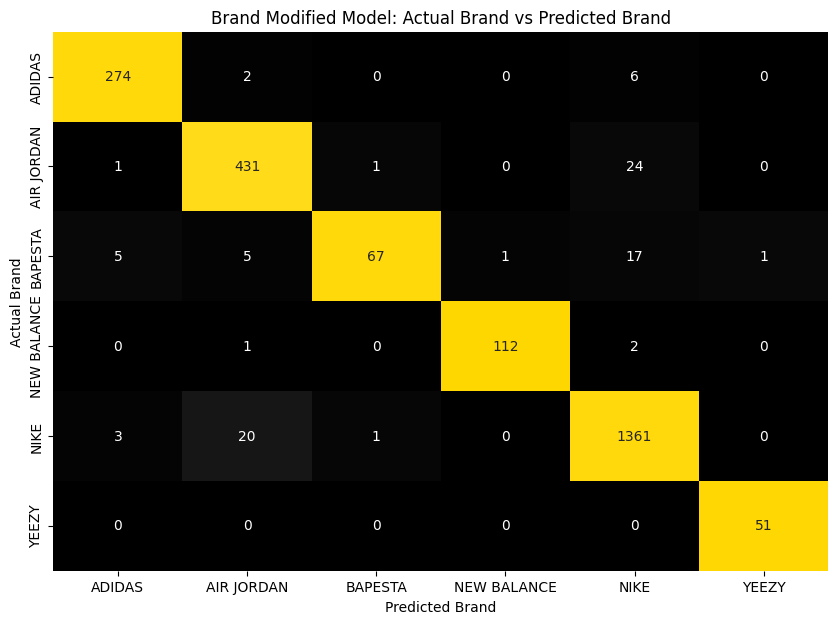

In [69]:
cm_df = pd.DataFrame(brand_modified_cm, index=brand_list, columns=brand_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Brand')
plt.xlabel('Predicted Brand')
plt.title('Brand Modified Model: Actual Brand vs Predicted Brand')
plt.show()

In [70]:
brand_modified_accuracy = accuracy_score(true_labels, predicted_labels)
brand_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
brand_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
brand_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
brand_modified_report = classification_report(true_labels, predicted_labels, target_names=brand_list)

brand_modified_metrics = pd.DataFrame([{
    'Model': 'Brand Modified Model',
    'Accuracy': brand_modified_accuracy,
    'Precision': brand_modified_precision,
    'Recall': brand_modified_recall,
    'F1 Score': brand_modified_f1
}])
metrics_df = pd.concat([metrics_df, brand_modified_metrics], ignore_index=True)


print(f"Brand Modified Accuracy: {brand_modified_accuracy}")
print(f"Brand Modified Precision: {brand_modified_precision}")
print(f"Brand Modified Recall: {brand_modified_recall}")
print(f"Brand Modified F1 Score: {brand_modified_f1}")
print(brand_modified_report)

Brand Modified Accuracy: 0.9622799664710813
Brand Modified Precision: 0.969229682360084
Brand Modified Recall: 0.9282066028282759
Brand Modified F1 Score: 0.9449516809981257
              precision    recall  f1-score   support

      ADIDAS       0.97      0.97      0.97       282
  AIR JORDAN       0.94      0.94      0.94       457
     BAPESTA       0.97      0.70      0.81        96
 NEW BALANCE       0.99      0.97      0.98       115
        NIKE       0.97      0.98      0.97      1385
       YEEZY       0.98      1.00      0.99        51

   micro avg       0.96      0.96      0.96      2386
   macro avg       0.97      0.93      0.94      2386
weighted avg       0.96      0.96      0.96      2386
 samples avg       0.96      0.96      0.96      2386



## Model Model Evaluation

In [71]:
model_list = ['NB 2002R', 'AIR MAX 1', 'NIKE AIR MAX 90', 'AJ 1','AJ 11', 'AJ 12', 'AJ 2', 
'AJ 3', 'AJ 4', 'AJ 5', 'AJ 6', 'BAPESTA', 'NIKE DUNK LOW','NIKE DUNK HIGH', 'NB550',
'NB990', 'ADIDAS STAN SMITH', 'YZY 700', 'YZY 350', 'YZY RNR', 'NIKE AF1', 
'ADIDAS FORUM', 'ADIDAS SAMBA', 'YZY SLIDES'
]

### Original 

In [72]:
true_labels = []
predicted_labels = []

binary_predictions_list = model_binary_predictions.tolist()
prediction_count = 0

for batch in model_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 24)
(2386, 24)


In [73]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
model_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(model_cm)


[[ 32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1 162   2   5   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0  23   0   0   0]
 [  0   2 207   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   3   0 243   1   0   5   0   0   0   0   0   2   3   0   0   0   0
    0   0   5   0   0   0]
 [  0   1   0   2  23   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1   0   0  19   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   4   0   0   0]
 [  0   0   0  18   0   0   6   0   0   0   0   0   0   0   0   0   0   0
    0   0   3   0   0   0]
 [  0   1   0   1   1   0   0  24   0   0   0   0   0   0   0   0   0   0
    0   0   5   0   0   0]
 [  0   0   0   2   0   0   0   0  21   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   4   0   0   2   0   0  31   0   1   2   2   0   0   0   0
    0   0   2   0

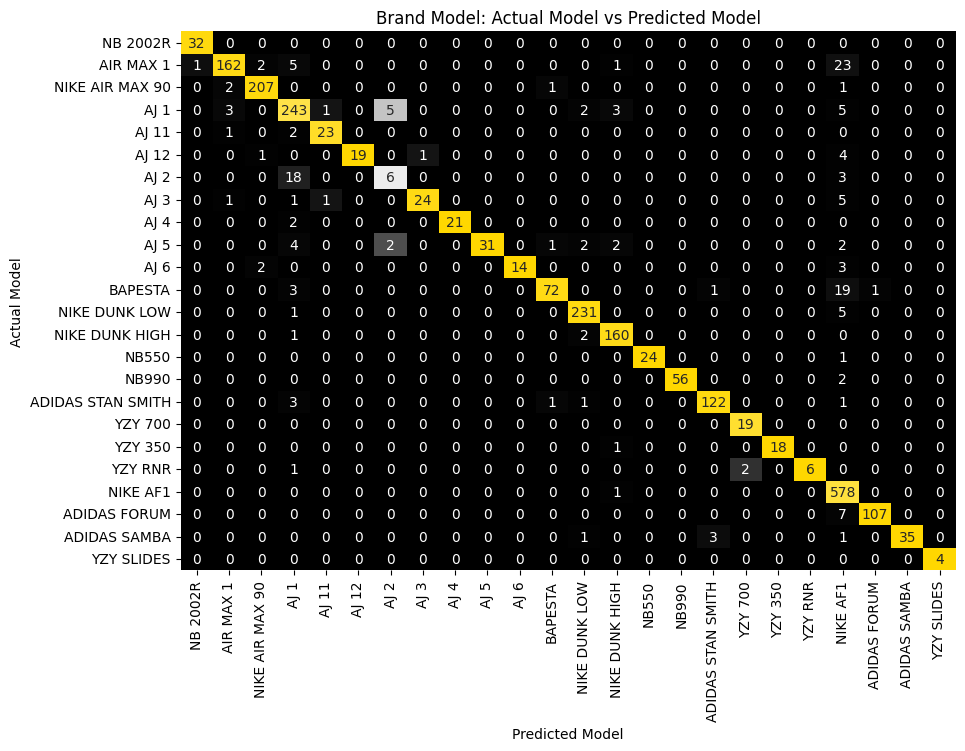

In [74]:
cm_df = pd.DataFrame(model_cm, index=model_list, columns=model_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Model')
plt.xlabel('Predicted Model')
plt.title('Brand Model: Actual Model vs Predicted Model')
plt.show()

In [75]:
model_accuracy = accuracy_score(true_labels, predicted_labels)
model_precision = precision_score(true_labels, predicted_labels, average='macro')
model_recall = recall_score(true_labels, predicted_labels, average='macro')
model_f1 = f1_score(true_labels, predicted_labels, average='macro')
model_report = classification_report(true_labels, predicted_labels, target_names=model_list)

model_metrics = pd.DataFrame([{
    'Model': 'Model Model',
    'Accuracy': model_accuracy,
    'Precision': model_precision,
    'Recall': model_recall,
    'F1 Score': model_f1
}])
metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)


print(f"Model Accuracy: {model_accuracy}")
print(f"Model Precision: {model_precision}")
print(f"Model Recall: {model_recall}")
print(f"Model F1 Score: {model_f1}")
print(model_report)

Model Accuracy: 0.9279128248113998
Model Precision: 0.9466786061915259
Model Recall: 0.8635695459290033
Model F1 Score: 0.8974512322607523
                   precision    recall  f1-score   support

         NB 2002R       0.97      1.00      0.98        32
        AIR MAX 1       0.96      0.84      0.89       194
  NIKE AIR MAX 90       0.98      0.98      0.98       211
             AJ 1       0.86      0.93      0.89       262
            AJ 11       0.92      0.88      0.90        26
            AJ 12       1.00      0.76      0.86        25
             AJ 2       0.46      0.22      0.30        27
             AJ 3       0.96      0.75      0.84        32
             AJ 4       1.00      0.91      0.95        23
             AJ 5       1.00      0.70      0.83        44
             AJ 6       1.00      0.74      0.85        19
          BAPESTA       0.96      0.75      0.84        96
    NIKE DUNK LOW       0.97      0.97      0.97       237
   NIKE DUNK HIGH       0.95      

### Modified 

In [76]:
true_labels = []
predicted_labels = []

binary_predictions_list = model_binary_mod_predictions.tolist()
prediction_count = 0

for batch in model_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 24)
(2386, 24)


In [77]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
model_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(model_modified_cm)

[[ 32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 175   1   3   0   0   0   2   0   0   0   0   1   0   0   1   0   0
    0   0  11   0   0   0]
 [  0   2 208   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   3   0 238   0   0  12   1   0   0   1   2   2   0   0   0   0   0
    0   0   3   0   0   0]
 [  0   2   0   0  22   0   0   1   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   1  21   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   2   0   0   0]
 [  0   0   0  10   0   0  14   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   2   0   0]
 [  0   0   0   1   0   0   0  29   0   0   0   0   0   0   0   0   0   0
    0   0   2   0   0   0]
 [  0   0   0   0   0   0   0   0  21   0   0   1   0   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   0   1   4   0   0   2   1   0  30   1   0   4   0   0   0   0   0
    0   0   1   0

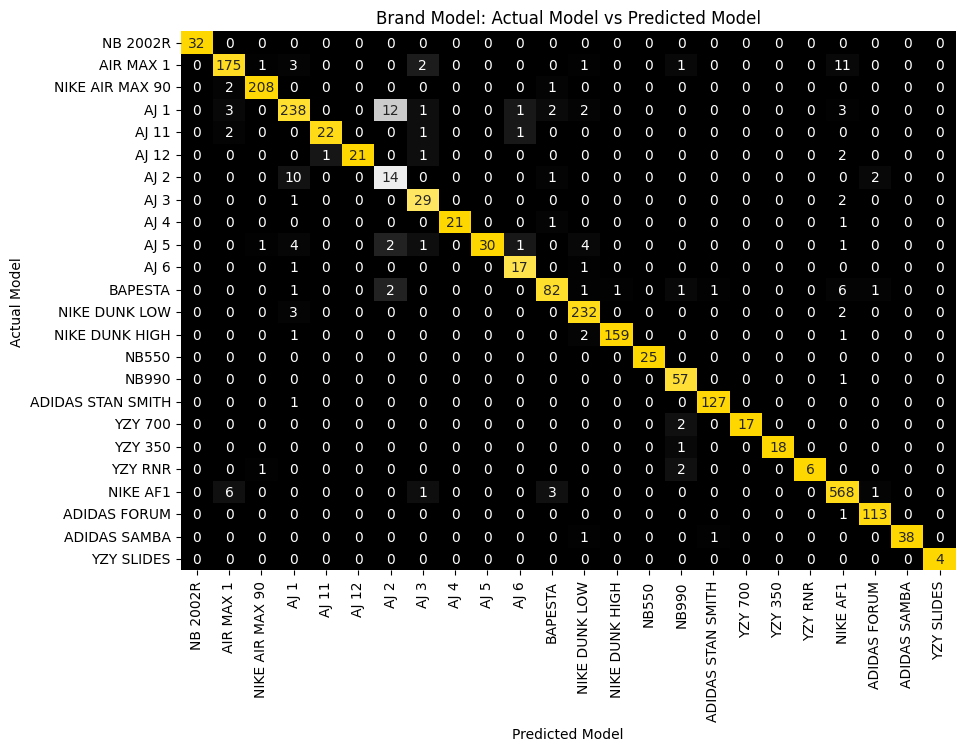

In [78]:
cm_df = pd.DataFrame(model_modified_cm, index=model_list, columns=model_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Model')
plt.xlabel('Predicted Model')
plt.title('Brand Model: Actual Model vs Predicted Model')
plt.show()

In [79]:
model_modified_accuracy = accuracy_score(true_labels, predicted_labels)
model_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
model_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
model_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
model_modified_report = classification_report(true_labels, predicted_labels, target_names=model_list)

model_modified_metrics = pd.DataFrame([{
    'Model': 'Modified Model Model',
    'Accuracy': model_modified_accuracy,
    'Precision': model_modified_precision,
    'Recall': model_modified_recall,
    'F1 Score': model_modified_f1
}])
metrics_df = pd.concat([metrics_df, model_modified_metrics], ignore_index=True)

print(f"Model Modified Accuracy: {model_modified_accuracy}")
print(f"Model Modified Precision: {model_modified_precision}")
print(f"Model Modified Recall: {model_modified_recall}")
print(f"Model Modified F1 Score: {model_modified_f1}")
print(model_modified_report)

Model Modified Accuracy: 0.9442581726739313
Model Modified Precision: 0.9393825388763574
Model Modified Recall: 0.9004683020987883
Model Modified F1 Score: 0.9162137660687112
                   precision    recall  f1-score   support

         NB 2002R       1.00      1.00      1.00        32
        AIR MAX 1       0.93      0.90      0.92       194
  NIKE AIR MAX 90       0.99      0.99      0.99       211
             AJ 1       0.90      0.91      0.91       262
            AJ 11       0.96      0.85      0.90        26
            AJ 12       1.00      0.84      0.91        25
             AJ 2       0.47      0.52      0.49        27
             AJ 3       0.81      0.91      0.85        32
             AJ 4       1.00      0.91      0.95        23
             AJ 5       1.00      0.68      0.81        44
             AJ 6       0.85      0.89      0.87        19
          BAPESTA       0.91      0.85      0.88        96
    NIKE DUNK LOW       0.95      0.98      0.96       23

# ALL MODELS

In [80]:
metrics_df.head(10)

,Model,Accuracy,Precision,Recall,F1 Score
0,Unbalanced Price Model,0.318106,0.236896,0.151465,0.144969
1,Unbalanced Modified Price Model,0.310142,0.200107,0.141307,0.127455
2,Balanced Price Model,0.195725,0.187009,0.193614,0.173161
3,Balanced Modified Price Model,0.183990,0.191892,0.181598,0.172396
4,Brand Model,0.953479,0.948708,0.935813,0.942103
5,Brand Modified Model,0.962280,0.969230,0.928207,0.944952
6,Model Model,0.927913,0.946679,0.863570,0.897451
7,Modified Model Model,0.944258,0.939383,0.900468,0.916214


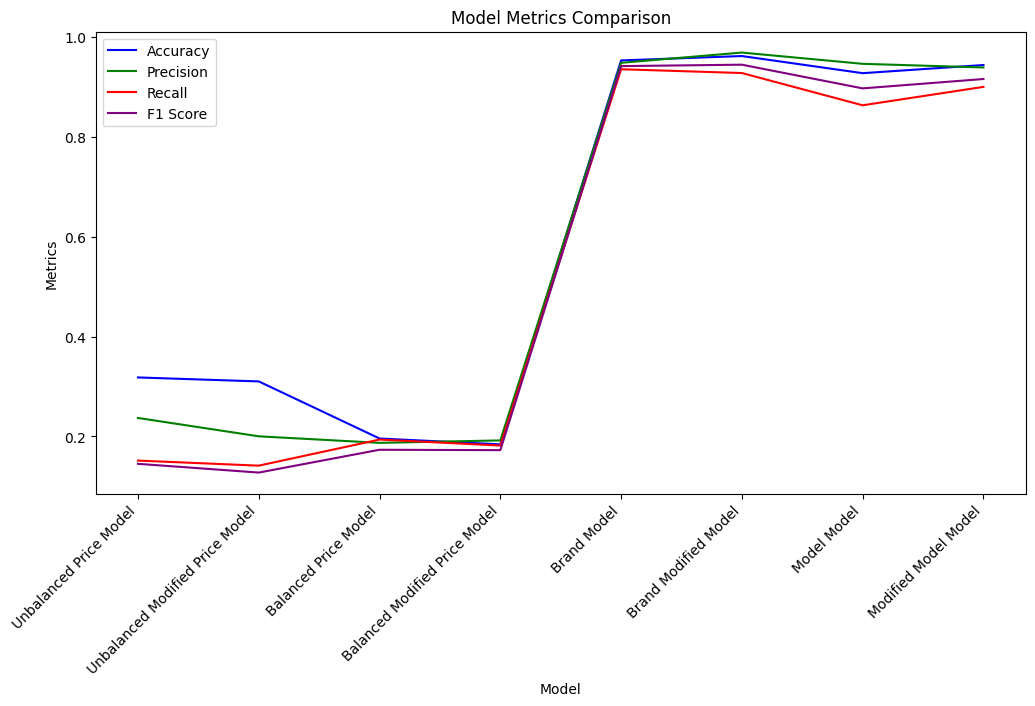

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Model'], metrics_df['Accuracy'], color='blue', label='Accuracy')
plt.plot(metrics_df['Model'], metrics_df['Precision'], color='green', label='Precision')
plt.plot(metrics_df['Model'], metrics_df['Recall'], color='red', label='Recall')
plt.plot(metrics_df['Model'], metrics_df['F1 Score'], color='purple', label='F1 Score')
plt.xlabel('Model')
plt.ylabel('Metrics')
plt.title('Model Metrics Comparison')
plt.xticks(rotation=45, ha="right") 
plt.legend()  
plt.show()